In [1]:
import geopandas
import contextily as ctx
import pandas as pd
import matplotlib.pyplot as plt
import ipyleaflet
import shapely
from colour import Color
from ipywidgets import HTML




numSpeedLevels = 30
firstColor = Color('blue')
lastColor = Color('red')

def click_Handler(**kwargs):
    print("ok")


def rawToDegrees(rawVal):
    """
    

    Parameters
    ----------
    rawVal : float
        lat/long as reported by gps. 1234.567890
        12 = degrees
        34 = minutes
        0.567890 = fraction of minute (*60 to get seconds)

    Returns
    -------
    FLOAT Converted to decimal degrees.

    """
    
    decDegrees = 0
    
    # extract the degrees, as reported by gps
    decDegrees += rawVal//100.0
    
    # remove this from the reading, left with minutes.fractionMinute
    rawVal = rawVal - 100.0*decDegrees
    
    # add minutes to decimal degrees
    decDegrees += (rawVal)/60.0
    
    # # remove from raw val, left with only fractionMinute
    # rawVal = rawVal - rawVal//1.0
    
    # # add last fractionMinute
    # decDegrees += rawVal*60.0
    
    return decDegrees


def determineSpeedLevel(curSpeed,maxSpeed,numLevels):
    """
    

    Parameters
    ----------
    maxSpeed : FLOAT
        Maximum speed in data set
    curSpeed : FLOAT
        Speed for which a level is to be determined
    numLevels : INT
        Number of levels to distinguish. Minimum 2

    Returns
    -------
    speedLevel : INT
        The determined speed level based on parameters

    """
    
    # assuming min speed always 0, determine how many levels
    levelGap = maxSpeed*1.0/(numLevels-1)
    
    # number of levels is the floor division of the current speed by the levelGap. 0 to numLevels-1
    level = curSpeed//levelGap
    
    return level


# Import the raw GPS data    
GPSdf = pd.read_csv('GPSDATA.txt', delimiter = ",")

# Add a dataNum column
GPSdf['dataNum'] = GPSdf.index

# convert the raw lat and long values to real lat and long
GPSdf['Latitude'] = GPSdf['rawLat'].apply(rawToDegrees)
GPSdf['Longitude'] = GPSdf['rawLong'].apply(rawToDegrees)

# Determine max speed and create speed levels
GPSdf['SpeedLevel'] = GPSdf['x6'].apply(determineSpeedLevel, args=(max(GPSdf['x6']),numSpeedLevels))
#GPSdf.head(16500)

# Create a list of Polylines from the speed segments
colors = list(firstColor.range_to(lastColor,numSpeedLevels))
len(colors)
#colors

30

In [2]:
# create a geopandas geodataframe from the data, passing through long and latitude (only 50% sure it needs to be flipped like 
# this)
gdf = geopandas.GeoDataFrame(GPSdf, geometry=geopandas.points_from_xy(GPSdf.Longitude*-1, GPSdf.Latitude))

gdfGrouped = gdf.groupby(['SpeedLevel'])

runLines = []

ind = 0
lastDataNum = -1
lastLevel = 0
curLine = []
for level, group in gdfGrouped:
    
    for DNUM,LAT,LONG,SPEED in zip(group.dataNum, group.Latitude, group.Longitude, group.x6): 
        # if consequetive
        if DNUM- 1 == lastDataNum:
            lastDataNum = DNUM
            lastLevel = level
            curLine.append((LAT, LONG*-1))

        # else, the data jumps
        else: 
            p = ipyleaflet.Polyline(locations = curLine, color=colors[int(level)].hex, fill=False, weight=5)
            p.on_click(click_Handler)
            p.popup = HTML(str(SPEED))
            runLines.append(p)
            curLine = []
            curLine.append((LAT, LONG*-1))
            curLine.append((LAT, LONG*-1)) # double append to avoid single point lines
            lastDataNum = DNUM
            lastLevel = level
    
    #l = [xy for xy in zip(g[1].Latitude, g[1].Longitude*-1)]
    #p = ipyleaflet.Polyline(locations = l, color=colors[ind].hex, fill=False)
    #runLines.append(p)
    #ind += 1
len(runLines)

1113

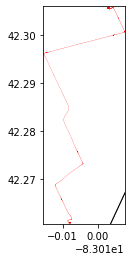

Map(center=[42.2833525, -83.01401908333334], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_…

In [3]:


# add the standard tag from openmaps
gdf.crs = "EPSG:4326"

# transform them in another geodataframe for other uses
gdf2 = gdf.to_crs(epsg=3857)



# get world dataset
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))

# We restrict to north america
ax = world[world.continent == 'North America'].plot(color='white', edgecolor='black')

# get min max coords of path
minx, miny, maxx, maxy = gdf.total_bounds

# set map zoom
mapZoom = 0.0001

# set axis according to map zoom and centre
ax.set_xlim(minx-mapZoom,maxx+mapZoom)
ax.set_ylim(miny-mapZoom,maxy+mapZoom)


# We can now plot our ``GeoDataFrame``. This is the basic white and red plot
gdf.plot(ax=ax, color='red', markersize=0.00001)
# ctx.add_basemap(ax, zoom = 18)

# save it
# plt.savefig('testOut.png', dpi=2000)
plt.show()

#basemap=basemaps.Gaode.Satellite


# get the map visualizer
m = ipyleaflet.Map(center=[(miny+maxy)/2, (minx+maxx)/2], zoom=6)
#m = ipyleaflet.Map(basemap=ipyleaflet.basemaps.Gaode.Satellite, center=[(miny+maxy)/2, (minx+maxx)/2], zoom=12)

#runData = ipyleaflet.GeoData(geo_dataframe=gdf)
geometry = [xy for xy in zip(gdf.Latitude, gdf.Longitude*-1)]
p = ipyleaflet.Polyline(locations = geometry, color="green", fill=False)
#m.add_layer(p)

for l in runLines:
    m.add_layer(l)

#m.add_layer(runData)
m.layout.height = "1000px"
m.scroll_wheel_zoom = True
m


#geometry



# plt.savefig('testOut.png', dpi=300)



# df = geopandas.read_file(geopandas.datasets.get_path('nybb'))
# ax = df.plot(figsize=(10, 10), alpha=0.5, edgecolor='k')

# df = df.to_crs(epsg=3857)

# ax = df.plot(figsize=(10, 10), alpha=0.5, edgecolor='k')
# ctx.add_basemap(ax)

# ax = df.plot(figsize=(10, 10), alpha=0.5, edgecolor='k')
# ctx.add_basemap(ax, zoom=12)